<a href="https://colab.research.google.com/github/lucarenz1997/recommender_systems/blob/main/data-prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCF (Neural Collaborative Filtering) Train model
** Authors **: Rafaella and Luca
## Provisorischer Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Loading the dataset
#import pandas as pd
#data = pd.read_csv("/content/drive/MyDrive/Recommender/train.csv")


import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

# Loading the dataset
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/Recommender/train.csv")


import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'google'

## NCF (Neural Collaborative Filtering) Train model

genre_id                 category
ts_listen          datetime64[ns]
media_id                 category
album_id                 category
context_type             category
release_date       datetime64[ns]
platform_name            category
platform_family          category
media_duration              int64
listen_type              category
user_gender                  bool
user_id                  category
artist_id                category
user_age                    int64
is_listened                  bool
dtype: object


In [4]:
data = data.dropna(subset=['release_date'])

## Outlier Removal
### Numerical data
This subchapter shows how outliers were identified and removed using one of the outlier removal methods called IQR.

When analyzing ts_listen, it was shown that most of the timestamps were after 2016 while less than one thousand songs were listened before 2016. Therefore, it has been decided to remove outliers.

ts_listen
1970-12-31        237
1973-12-31          0
1976-12-31          0
1979-12-31          0
1982-12-31        379
1985-12-31          0
1988-12-31          0
1991-12-31          0
1994-12-31          0
1997-12-31          1
2000-12-31          0
2003-12-31          2
2006-12-31          0
2009-12-31        108
2012-12-31         12
2015-12-31         48
2018-12-31    7151901
Freq: 3YE-DEC, dtype: int64
Removing outliers from ts_listen with lower boundary of 2016-10-15 13:10:32.375000320 and upper boundary of 2016-12-13 21:35:53.374999808


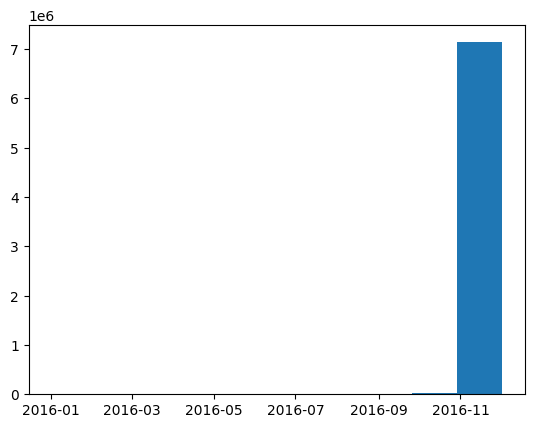

In [8]:
# Grouping by 5-year intervals to see the approximate counts
grouped_data = data.groupby(pd.Grouper(key='ts_listen', freq='3YE')).size()
print(grouped_data) # We can start at 2016

len(data[data['ts_listen'] < pd.Timestamp('2015-12-31')])

tmp = data[data['ts_listen'] > pd.Timestamp('2015-12-31')]
plt.hist(tmp['ts_listen'])

# outlier removal
data = remove_outliers(data,'ts_listen')

(array([5.40000e+01, 1.21000e+02, 3.70000e+02, 7.58000e+02, 9.34000e+02,
        9.97000e+02, 1.38700e+03, 1.29000e+03, 1.78700e+03, 2.02100e+03,
        2.73500e+03, 4.90800e+03, 5.19500e+03, 3.65690e+04, 3.24259e+05,
        3.85581e+05, 4.01821e+05, 3.85558e+05, 2.77370e+05, 2.81870e+05,
        3.18830e+05, 3.33942e+05, 3.66025e+05, 3.00396e+05, 2.19057e+05,
        2.76626e+05, 2.85963e+05, 3.13078e+05, 2.96868e+05, 2.54893e+05,
        2.00035e+05, 2.51509e+05, 2.62013e+05, 2.52500e+05, 2.35281e+05,
        2.04819e+05, 1.85820e+05, 1.97627e+05, 1.88008e+05, 9.11160e+04]),
 array([17089.58644676, 17090.77150926, 17091.95657176, 17093.14163426,
        17094.32669676, 17095.51175926, 17096.69682176, 17097.88188426,
        17099.06694676, 17100.25200926, 17101.43707176, 17102.62213426,
        17103.80719676, 17104.99225926, 17106.17732176, 17107.36238426,
        17108.54744676, 17109.73250926, 17110.91757176, 17112.10263426,
        17113.28769676, 17114.47275926, 17115.65782176

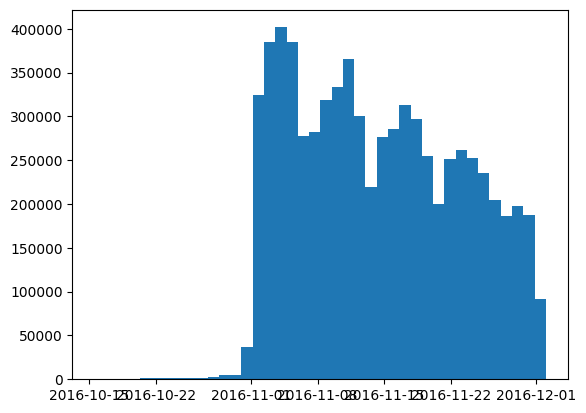

In [9]:
# After outlier removal
plt.hist(data['ts_listen'], bins=40)

{'whiskers': [<matplotlib.lines.Line2D at 0x7891f4c51450>,
 'caps': [<matplotlib.lines.Line2D at 0x7891f4c52850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7891f4c50c90>],
 'medians': [<matplotlib.lines.Line2D at 0x7891f4c53b50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7891f4c68610>],
 'means': []}

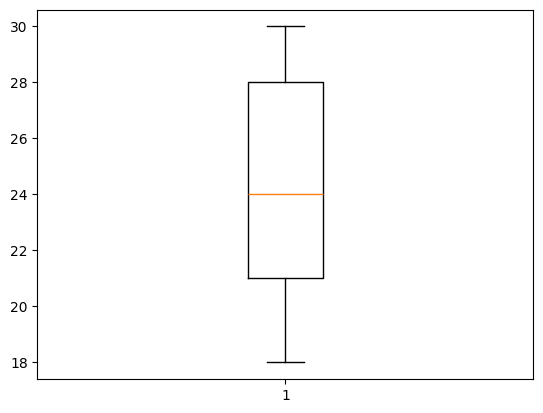

In [10]:
plt.boxplot(data['user_age']) # no outliers here. Ages between 18 and 30

# Sampling
Due to performance issues, it was not possible to perform complex calculations. therefore, it has been decided to only use a subset of the given data.
In this case, we want to keep the distribution in respect to the usage of users.

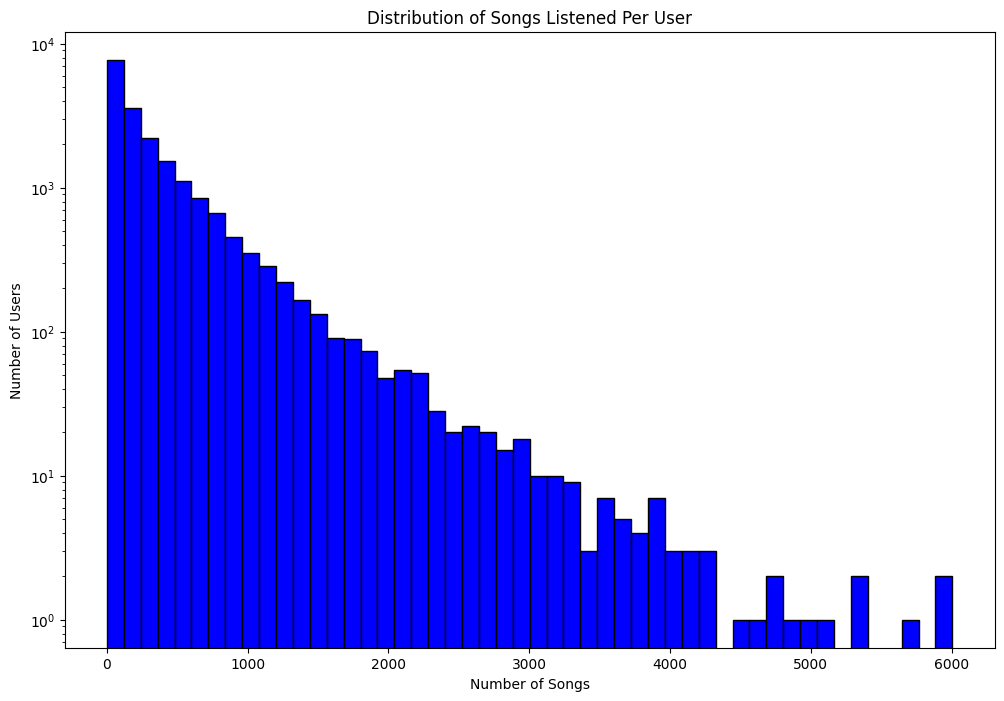

In [11]:
user_song_counts = data.groupby('user_id')['media_id'].count()

# Create the histogram
plt.figure(figsize=(12, 8))
plt.hist(user_song_counts, bins=50, color='blue', edgecolor='black')
plt.yscale('log')
plt.title('Distribution of Songs Listened Per User')
plt.xlabel('Number of Songs')
plt.ylabel('Number of Users')
plt.show()

In [12]:
user_song_counts.describe()

,media_id
count,19918.000000
mean,358.971332
std,480.852396
min,0.000000
25%,62.000000
50%,186.000000
75%,468.000000
max,6006.000000


In [13]:
import pandas as pd
fraction = 0.2

# Calculate the total number of songs each user has listened to
user_song_counts = data.groupby('user_id')['media_id'].count()

# Bin these counts into categories
bins = [0, 60, 190, 500, float('inf')]  # 25th, 50th, 75th percentile
labels = ['low', 'medium', 'high', 'very high']
data['activity_level'] = pd.cut(user_song_counts, bins=bins, labels=labels, right=False)

# Join this back to the main dataset
data = data.join(data['user_id'].map(data['activity_level']), on='user_id', rsuffix='_r')

# Perform stratified sampling
sampled_data = data.groupby('activity_level', group_keys=False).apply(lambda x: x.sample(frac=fraction, random_state=42))


In [14]:
# Calculate proportions of each activity level in the ORIGINAL data
original_proportions = data['activity_level'].value_counts(normalize=True)
print("Original Data Proportions:\n", original_proportions)

# Calculate proportions of each activity level in the SAMPLED data
sample_proportions = sampled_data['activity_level'].value_counts(normalize=True)
print("Sampled Data Proportions:\n", sample_proportions)


Original Data Proportions:
 activity_level
medium       0.265475
high         0.260036
low          0.242321
very high    0.232168
Name: proportion, dtype: float64
Sampled Data Proportions:
 activity_level
medium       0.265475
high         0.260036
low          0.242424
very high    0.232064
Name: proportion, dtype: float64


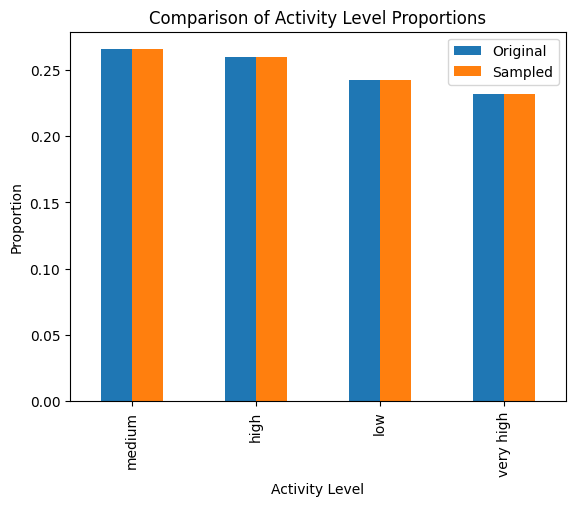

In [15]:
import matplotlib.pyplot as plt

# Create a DataFrame to hold the proportions
comparison_df = pd.DataFrame({
    'Original': original_proportions,
    'Sampled': sample_proportions
})

comparison_df.plot(kind='bar')
plt.title('Comparison of Activity Level Proportions')
plt.ylabel('Proportion')
plt.xlabel('Activity Level')
plt.show()


# Dimension Reduction
For many features such as genre_id, artist_id, etc. there are several thousand unique values. Therefore, to not stretch our matrices unnecessarily and remove complexity, it has been decided to use minimum thresholds for specific categories which will reduce dimensions.

In [42]:
genre_counts = sampled_data.groupby('genre_id')['genre_id'].count()

# Filter out genres that appear less than a threshold
threshold = 1
rare_genres = genre_counts[genre_counts < threshold].index

# Filter your data to only include songs with these genres
filtered_data = sampled_data[~sampled_data['genre_id'].isin(rare_genres)]

print(f"There are {len(rare_genres)} genres with fewer than {threshold} streams in the dataset.")
print(f"This corresponds to {round(len(rare_genres) * 100 / len(genre_counts), 2)}% of all streams.\n")

There are 2818 genres with fewer than 1 streams in the dataset.
This corresponds to 96.44% of all streams.



In [43]:
genre_counts

,genre_id
genre_id,
0,4
1,4
2,3
3,41
4,0
...,...
257431,0
258111,0
258911,0


# Feature Engineering

In [15]:
# Feature Engineering
sampled_data["genre_popularity"] = sampled_data.groupby('genre_id')['genre_id'].transform('count')
sampled_data["media_popularity"] = sampled_data.groupby('media_id')['media_id'].transform('count')
sampled_data["artist_popularity"] = sampled_data.groupby('artist_id')['artist_id'].transform('count')
sampled_data["album_popularity"] = sampled_data.groupby('album_id')['album_id'].transform('count')
sampled_data['songs_listened'] = sampled_data.groupby('user_id')['media_id'].transform('count')

user_top_genre = sampled_data.groupby(['user_id', 'genre_id']).size().groupby(level=0).idxmax().apply(lambda x: x[1])
sampled_data['user_top_genre'] = sampled_data['user_id'].map(user_top_genre)

# Not possible due to limited resources
# user_top_artist = sampled_data.groupby(['user_id', 'artist_id']).size().groupby(level=0).idxmax().apply(lambda x: x[1])
# sampled_data['user_top_artist'] = sampled_data['user_id'].map(user_top_artist)

# user_top_song = sampled_data.groupby(['user_id', 'media_id']).size().groupby(level=0).idxmax().apply(lambda x: x[1])
# sampled_data['user_top_song'] = sampled_data['user_id'].map(user_top_song)



In [16]:
sampled_data

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,...,user_age,is_listened,activity_level,user_id_r,genre_popularity,media_popularity,artist_popularity,album_popularity,songs_listened,user_top_genre
17685,6129,2016-11-23 11:03:38,76565888,7594557,17,2014-05-19,2,1,197,0,...,28,True,low,very high,10,1,10,10,6,6129
14353,2525,2016-11-05 10:48:13,59506771,5814071,1,2012-09-24,0,2,163,1,...,28,True,low,very high,127,113,126,126,1,2525
18916,27,2016-12-01 09:52:36,86453925,8722185,1,2014-10-05,0,0,227,1,...,30,True,low,very high,517,268,268,268,1,27
19622,2744,2016-11-03 15:54:20,88552805,8947947,1,2014-11-03,0,0,189,1,...,21,False,low,very high,281,8,8,8,1,2744
18716,27,2016-11-29 21:00:23,86453925,8722185,1,2014-10-05,2,1,227,1,...,26,False,low,medium,517,268,268,268,2,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,2744,2016-11-03 18:16:33,876497,99692,0,1985-12-31,1,0,307,0,...,27,True,very high,very high,281,86,272,272,1,2744
2318,7,2016-11-07 19:44:11,1121220,120574,1,2007-10-29,0,0,174,1,...,28,False,very high,high,659,3,15,15,3,7
3074,7,2016-11-20 00:24:53,2438251,240153,2,2002-12-31,1,2,197,0,...,29,True,very high,very high,659,9,20,234,7,7
4017,7,2016-11-08 10:11:54,2476197,243305,0,2008-11-03,2,1,166,0,...,28,False,very high,very high,659,1,21,21,8,7
